* 整理自链接： https://hrl.boyuai.com/chapter/2/%E7%AD%96%E7%95%A5%E6%A2%AF%E5%BA%A6%E7%AE%97%E6%B3%95

&&  https://gymnasium.farama.org/tutorials/training_agents/reinforce_invpend_gym_v26/

——————

- [x] 没有考虑随机种子的影响
- [ ] 没有存储训练好的网络权重
- [ ] 没有在 环境中 试运行策略

——————

REINFORCE 算法理论上是能保证局部最优的，它实际上是借助**蒙特卡洛方法**采样轨迹来**估计动作价值**，这种做法的一大优点是可以得到**无偏的梯度**。但是，正是因为使用了蒙特卡洛方法，REINFORCE 算法的梯度估计的<font color=red>**方差很大**</font>，可能会造成一定程度上的不稳定，这也是第 10 章将介绍的 Actor-Critic 算法要解决的问题。

## 代码模块

In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 17.3 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 这样 无需 plt.show()  直接在代码单元下方显示图
from tqdm import tqdm
import random
# import rl_utils

# https://github.com/boyu-ai/Hands-on-RL/blob/main/rl_utils.py

import warnings   # 忽略警告
warnings.filterwarnings("ignore")

### 策略网络

输入： 某个状态

输出： 该状态下的动作概率分布

In [ ]:
class PolicyNet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(PolicyNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    return F.softmax(self.fc2(x), dim=1)

### REINFORCE 算法

In [ ]:
class REINFORCE:
  def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device):
    self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
    self.optimizer = torch.optim.Adam(self.policy_net.parameters(),lr=learning_rate) # 优化器
    self.gamma = gamma #折扣因子
    self.device = device

  def sample_action(self, state): #
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    probs = self.policy_net(state)
    action = torch.distributions.Categorical(probs).sample().item()
    return action

  def update(self, transition_dict): # 每回合 更新一次
    reward_list = transition_dict['rewards']
    state_list = transition_dict['states']
    action_list = transition_dict['actions']


    G = 0  # 回报
    self.optimizer.zero_grad() # 梯度重置
    for i in reversed(range(len(reward_list))): # T-1, T-2,...,0  时间步
      reward = reward_list[i]
      state = torch.tensor([state_list[i]], dtype=torch.float).to(self.device)
      action = torch.tensor([action_list[i]]).view(-1,1).to(self.device)  # .view(-1,1) 将张量重新塑造为一个列数为 1，行数自动推断的二维张量。
      log_prob = torch.log(self.policy_net(state).gather(1,action))  # 默认是以 e 为底的   # Tensor.gather(dim, index) → Tensor
      G = self.gamma * G + reward  # G←γG + r_{t+1}
      loss = -log_prob * G
      loss.backward()  # 反向传播
    self.optimizer.step()   # 更新


## 训练


环境链接： https://gymnasium.farama.org/environments/classic_control/cart_pole/

<font size=5, color=red>用时较久 ！！！

调试时 可考虑 将下面的  **total_num_episodes 调小些**，尝试更多改进方案。或 仅希望快些跑通</font>

In [ ]:
# Create and wrap the environment
env_name = "CartPole-v1"
env = gym.make(env_name)
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward
# # deque_size – The size of the buffers return_queue and length_queue  本代码中 打印的回报均值 为 50 个回合的均值

total_num_episodes = int(5e3)  # Total number of episodes  5000
hidden_dim = 128
learning_rate = 1e-3
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

# Observation-space of
obs_space_dims = env.observation_space.shape[0]
# Action-space of
action_space_dims = env.action_space.n
rewards_over_seeds = []

for seed in [1, 2, 3, 5, 8]:  # Fibonacci seeds
    # set seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    agent = REINFORCE(obs_space_dims, hidden_dim, action_space_dims, learning_rate, gamma,
                  device)
    reward_over_episodes = []

    for episode in range(total_num_episodes):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)
        transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }

        done = False
        while not done:
            action = agent.sample_action(obs)

            # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
            # These represent the next observation, the reward from the step,
            # if the episode is terminated, if the episode is truncated and
            # additional info from the step
            next_obs, reward, terminated, truncated, info = wrapped_env.step(action)
            transition_dict['states'].append(obs)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_obs)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            obs = next_obs

            # End the episode when either truncated or terminated is true
            #  - truncated: The episode duration reaches max number of timesteps
            #  - terminated: Any of the state space values is no longer finite.
            done = terminated or truncated

        reward_over_episodes.append(wrapped_env.return_queue[-1])
        agent.update(transition_dict)

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds.append(reward_over_episodes)

Episode: 0 Average Reward: 23
Episode: 1000 Average Reward: 149
Episode: 2000 Average Reward: 130
Episode: 3000 Average Reward: 479
Episode: 4000 Average Reward: 399
Episode: 0 Average Reward: 436
Episode: 1000 Average Reward: 400
Episode: 2000 Average Reward: 136
Episode: 3000 Average Reward: 471
Episode: 4000 Average Reward: 500
Episode: 0 Average Reward: 473
Episode: 1000 Average Reward: 455
Episode: 2000 Average Reward: 493
Episode: 3000 Average Reward: 478
Episode: 4000 Average Reward: 436
Episode: 0 Average Reward: 490
Episode: 1000 Average Reward: 180
Episode: 2000 Average Reward: 475
Episode: 3000 Average Reward: 249
Episode: 4000 Average Reward: 491
Episode: 0 Average Reward: 241
Episode: 1000 Average Reward: 383
Episode: 2000 Average Reward: 469
Episode: 3000 Average Reward: 500
Episode: 4000 Average Reward: 500


## 可视化

https://seaborn.pydata.org/generated/seaborn.lineplot.html

[Text(0.5, 1.0, 'REINFORCE for CartPole-v1')]

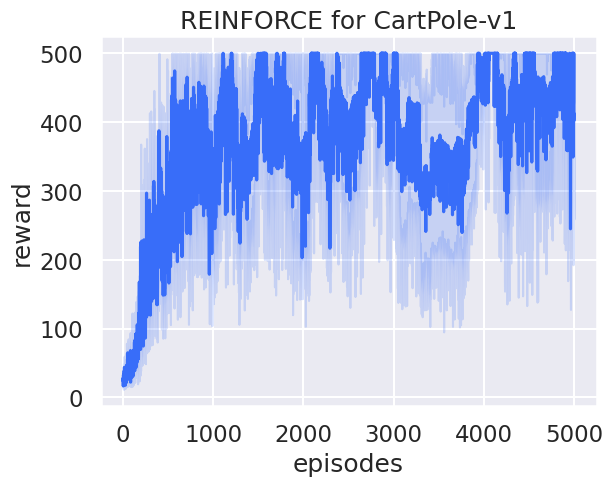

In [ ]:
import pandas as pd
import seaborn as sns

rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds]

df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="REINFORCE for {}".format(env_name)
)

[Text(0.5, 1.0, 'REINFORCE for CartPole-v1')]

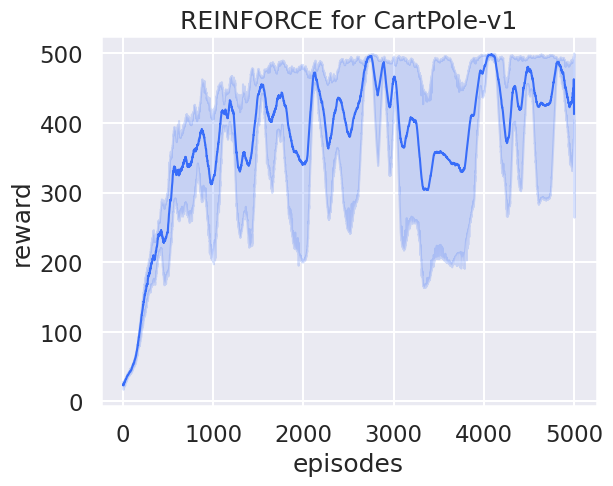

In [11]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds]
# print(rewards_to_plot)
for i in range(len(rewards_to_plot)):
  rewards_to_plot[i] = moving_average(rewards_to_plot[i], 69) # 调这里 更改平滑度

# rewards_to_plot = [[reward[0] for reward in np.array(moving_average(rewards, window_size=29))] for rewards in rewards_over_seeds]
df1 = pd.DataFrame(rewards_to_plot).melt()  #  .rolling(window=30).mean()

df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1, linewidth=1.5).set(
    title="REINFORCE for {}".format(env_name)
)   # 调线宽

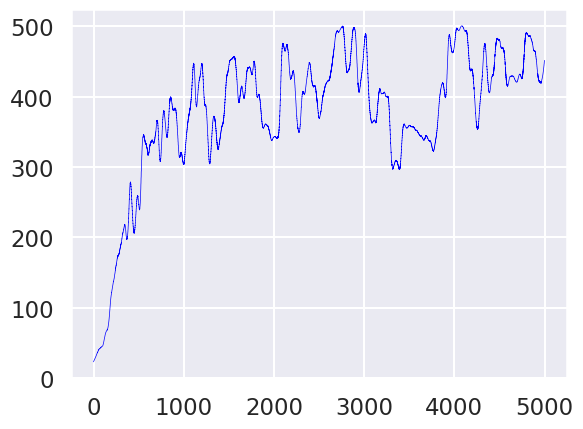

In [ ]:
from scipy.signal import savgol_filter
%matplotlib inline

# 应用平滑滤波器
window_size = 300  # 窗口大小，即平滑的程度
polyorder = 2     # 多项式的阶数

# 对 y 值使用 savgol_filter
smoothed_y = savgol_filter(df1['reward'], window_length=window_size, polyorder=polyorder)

# 绘制平滑后的线图
plt.plot(df1['episodes'], smoothed_y, color='blue', linewidth=0.5)   # 2

### 一些训练结果

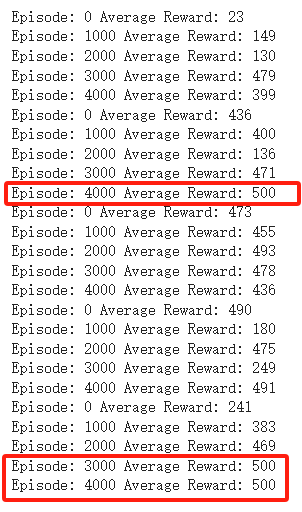

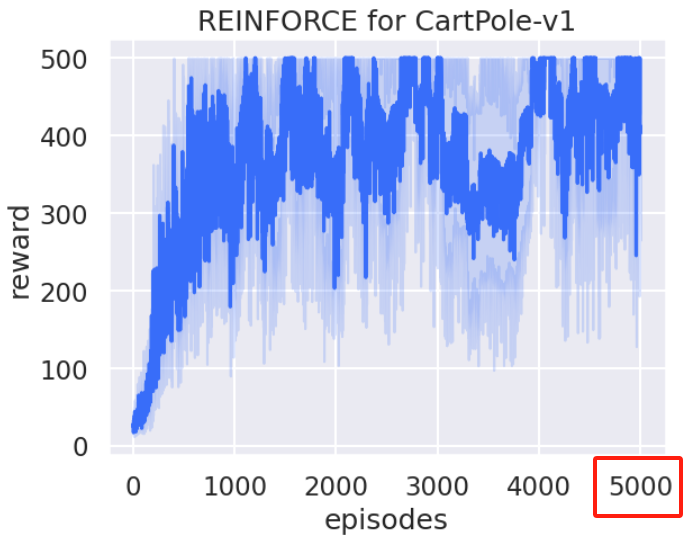

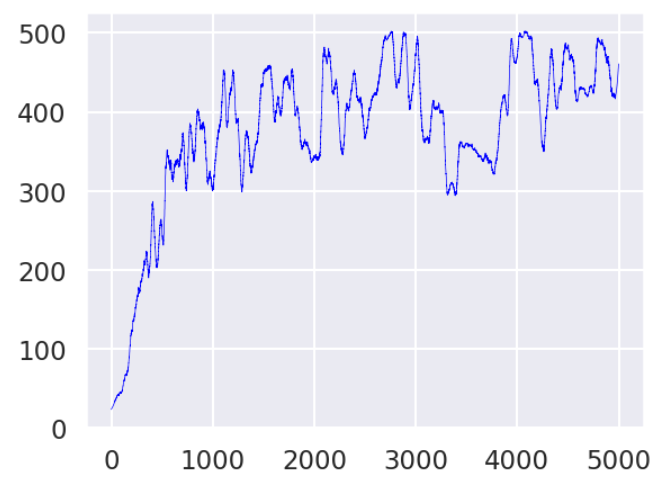

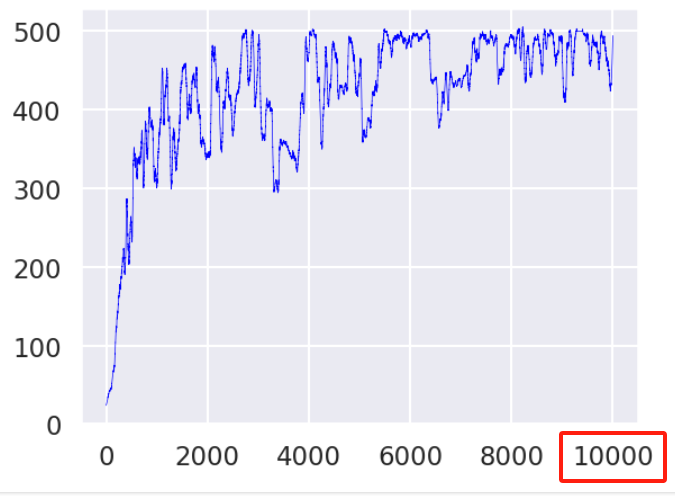

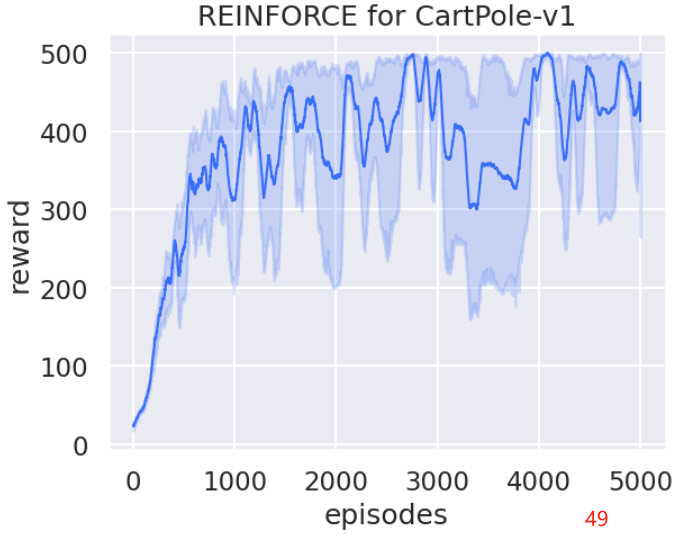